# Claimable Liquidity from V3 Pool

In [73]:
load_from_ledger = False

if load_from_ledger:
    pool = Contract(address='0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640')

    with pool.ledger.events.Mint as q:
        df_mint = q.select(columns=q.columns,
                        order_by=q.EVT_BLOCK_NUMBER.comma_(q.EVT_INDEX),
                        limit=5000
                        ).to_dataframe()

    with pool.ledger.events.Burn as q:
        df_burn = q.select(columns=q.columns,
                        order_by=q.EVT_BLOCK_NUMBER.comma_(q.EVT_INDEX),
                        # where=q.EVT_BLOCK_NUMBER.le(12384601)
                        limit=5000).to_dataframe()

    df_mint.to_csv('csv/uni_mint_5k.csv', index=False)
    df_burn.to_csv('csv/uni_burn_5k.csv', index=False)
else:
    df_mint = pd.read_csv('csv/uni_mint_5k.csv')
    df_burn = pd.read_csv('csv/uni_burn_5k.csv')


df_mint = df_mint.query('evt_block_number <= 12823596').astype({'inp_amount': 'float', 'inp_amount0': 'float', 'inp_amount1': 'float'})
df_burn = df_burn.query('evt_block_number <= 12823596').astype({'inp_amount': 'float', 'inp_amount0': 'float', 'inp_amount1': 'float'})

In [74]:
%load_ext credmark.cmf.ipython

param = {'chain_id': 1,
 'block_number': 15269596,
 'model_loader_path': ['../../credmark-models-py/models'],
 'chain_to_provider_url': {'1': 'http://192.168.68.122:10444'},
 'api_url': None,
 'use_local_models': '*',
 'register_utility_global': True}

context, model_loader = %cmf param

The credmark.cmf.ipython extension is already loaded. To reload it, use:
  %reload_ext credmark.cmf.ipython


In [132]:
df_mintburn = (pd
    .concat([df_mint.assign(type='mint',),
             df_burn.assign(type='burn', inp_amount = lambda x: -x.inp_amount)])
    .sort_values(['evt_block_number', 'evt_index'])
    .reset_index(drop=True))
    
display(df_mintburn.inp_owner.unique())
display(df_mintburn)

array(['0xC36442b4a4522E871399CD717aBDD847Ab11FE88',
       '0xa0127ad0f03bd1CE1D68d4820246db40F16C5688',
       '0x26f655245589eAc80f3F8e288A77e25899674a49',
       '0xd8C5e675f3D9Fa5F55f86eee5BB81D159D461eC9',
       '0x6f3F35a268B3af45331471EABF3F9881b601F5aA',
       '0x325441FdB3bd45a8093994303cF9B67f3689aC11',
       '0xB8B03BefFe0A033B11946F65cc6DD9767d5Ec936',
       '0x5e4aEc4E2eC0dF9d5C6433b03af20d7386A4678E',
       '0x5eDa709CAf6c57391F2Ac82BD39A4ef9DE181650',
       '0x2CB9a670EB42cf86a47b9eFDB318f402Ad06188e',
       '0xBFdf08b1B5b28cA1a0FED5edbd8943685569e382',
       '0x0507856599f598d2aA070c4286D296CD7Ef7AF9a',
       '0xB7E6E197792737a7DDD5F175421532F5616E1D7a',
       '0x215852Cc03263496969d8a5daa96f569B176771f',
       '0x759704b23a25bC8cdb90859D9D99Fe45a58031A4',
       '0x6fb6a8383574cA2da4f7d1c1B52b423eeD383752',
       '0x6c57F51f88b1898967734d8117c854C15810fF40',
       '0xf5F30EaF55Fd9fFc70651b13b791410aAd663846'], dtype=object)

,contract_address,evt_block_number,evt_tx_hash,evt_index,inp_sender,inp_owner,inp_ticklower,inp_tickupper,inp_amount,inp_amount0,inp_amount1,type
0,0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640,12376729,0x125e0b641d4a4b08806bf52c0c6757648c9963bcda86...,106,0xC36442b4a4522E871399CD717aBDD847Ab11FE88,0xC36442b4a4522E871399CD717aBDD847Ab11FE88,191150,198080,3.450731e+14,2995507735,999999999871526500,mint
1,0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640,12376958,0x7258050fbb90fa41f73505c552a973113ffc87c67ddd...,122,NaN,0xC36442b4a4522E871399CD717aBDD847Ab11FE88,191150,198080,-3.105658e+14,2588187276,931484249884373900,burn
2,0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640,12376958,0x7258050fbb90fa41f73505c552a973113ffc87c67ddd...,124,NaN,0xC36442b4a4522E871399CD717aBDD847Ab11FE88,191150,198080,-0.000000e+00,0,0,burn
3,0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640,12377035,0xa564ea4677bda271bbb2eebec9774577b9b101c46eaf...,195,0xC36442b4a4522E871399CD717aBDD847Ab11FE88,0xC36442b4a4522E871399CD717aBDD847Ab11FE88,194990,195010,2.565271e+13,1000000,145737680853531,mint
4,0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640,12377266,0xef93747acabe06ab11f663321f0de466bf9ae35888ba...,286,0xC36442b4a4522E871399CD717aBDD847Ab11FE88,0xC36442b4a4522E871399CD717aBDD847Ab11FE88,186730,195460,4.479946e+14,598469729,2599999995846641700,mint
...,...,...,...,...,...,...,...,...,...,...,...,...
9243,0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640,12823588,0x0f215e289b6060ac7479872f6c3cb9da3490a86577ec...,185,NaN,0xf5F30EaF55Fd9fFc70651b13b791410aAd663846,200880,201030,-4.298522e+15,956691230,233074979405963330,burn
9244,0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640,12823588,0x0f215e289b6060ac7479872f6c3cb9da3490a86577ec...,191,0xf5F30EaF55Fd9fFc70651b13b791410aAd663846,0xf5F30EaF55Fd9fFc70651b13b791410aAd663846,200870,201030,3.546402e+15,789297361,233074979405963300,mint
9245,0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640,12823588,0x0f215e289b6060ac7479872f6c3cb9da3490a86577ec...,193,0xf5F30EaF55Fd9fFc70651b13b791410aAd663846,0xf5F30EaF55Fd9fFc70651b13b791410aAd663846,200930,201030,7.741014e+14,167393869,0,mint
9246,0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640,12823596,0x84491d7e116e8c267889a52f7c73db425ace4f68f69c...,11,0xC36442b4a4522E871399CD717aBDD847Ab11FE88,0xC36442b4a4522E871399CD717aBDD847Ab11FE88,200900,200910,3.659173e+20,7942416453334,0,mint


In [183]:
from collections import namedtuple

Position = namedtuple('Position', 'lower upper owner')
# Detail = namedtuple('Detail', 'liquidity block_number')

minted = {}
burnt = {}
live = {}

df_mintburn_sel = df_mintburn.copy()

txs = [
    '0xf7cfb00ba9d3c345b3ae86ae5ad3dc14a1d9dfdb6fd9ebc27bb1f136f8f38dab',
    '0x0c1eeb912c9add530736727a1ef96eddf0e278fa591100b19bd0b8b5570983aa',
    '0x9ecc56d87aa0dedaecd8e3677ffda5a16d4f3680eb9c390b75b3867738788f8a',
    '0x639c66d0c0c3db3e20cdef0174c23ff55cefdc94eb58bb56302a66e81b65dc75',
    '0x01e6075f0d77b0ffc7bdcf8cd9075ffce4ce09486df501cfc699b2c3bf0e58dd',
    '0x1970aacba12439dc36e20a1da484a3e98169ef23e3125cd30c83bfbfd8b9e597',
]

# df_mintburn_sel = df_mintburn.query('evt_tx_hash.isin(@txs)').reset_index(drop=True)

for n,r in df_mintburn_sel.iterrows():
    pos = Position(r.inp_ticklower, r.inp_tickupper, r.inp_owner)
    detail = dict(liquidity=r.inp_amount, block_number=[r.evt_block_number], tx_hash=[r.evt_tx_hash])
    if r.type == 'mint':
        if pos in minted:
            minted[pos]['liquidity'] += detail['liquidity']
            minted[pos]['block_number'].extend(detail['block_number'])
            minted[pos]['tx_hash'].extend(detail['tx_hash'])
        else:
            minted[pos] = detail

        if pos in live:
            live[pos]['liquidity'] += detail['liquidity']
            live[pos]['block_number'] = detail['block_number']
            live[pos]['tx_hash'] = detail['tx_hash']
        else:
            live[pos] = detail.copy()
    
    else:
        if pos in burnt:
            burnt[pos]['liquidity'] += detail['liquidity']
            burnt[pos]['block_number'].extend(detail['block_number'])
            burnt[pos]['tx_hash'].extend(detail['tx_hash'])
        else:
            burnt[pos] = detail

        if pos in live:
            assert detail['block_number'][0] >= live[pos]['block_number'][0]
            liquidity_updated = live[pos]['liquidity'] + detail['liquidity']
            assert liquidity_updated >= -100000
            live[pos]['liquidity'] = liquidity_updated
            live[pos]['block_number'] = detail['block_number']
            live[pos]['tx_hash'] = detail['tx_hash']
        else:
            raise ValueError(f'{pos} not found in live')

AssertionError: 

<AxesSubplot:xlabel='evt_block_number'>

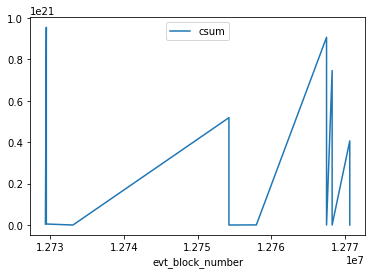

In [193]:
(df_mintburn.query('(inp_ticklower == 199270) and (inp_tickupper == 199280) and (inp_owner == "0xC36442b4a4522E871399CD717aBDD847Ab11FE88")')
    .assign(csum=lambda x: x.inp_amount.cumsum())
    .plot('evt_block_number', 'csum'))

In [185]:
pos, liquidity_updated, detail

(Position(lower=199270, upper=199280, owner='0xC36442b4a4522E871399CD717aBDD847Ab11FE88'),
 -131072.0,
 {'liquidity': -9.067305276832569e+20,
  'block_number': [12767525],
  'tx_hash': ['0x8a70f90eed5db1a41bd1ee4d957958edbe17f829e3151d5fdb2a16b2f836d13e']})

In [156]:
display(df_mintburn_sel)

display(df_mintburn_sel.inp_amount.sum())

,contract_address,evt_block_number,evt_tx_hash,evt_index,inp_sender,inp_owner,inp_ticklower,inp_tickupper,inp_amount,inp_amount0,inp_amount1,type
119,0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640,12398439,0xf7cfb00ba9d3c345b3ae86ae5ad3dc14a1d9dfdb6fd9...,210,0xC36442b4a4522E871399CD717aBDD847Ab11FE88,0xC36442b4a4522E871399CD717aBDD847Ab11FE88,192180,195210,8.789566e+15,42596779830,9611305227467330000,mint
129,0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640,12404683,0x0c1eeb912c9add530736727a1ef96eddf0e278fa5911...,261,0xC36442b4a4522E871399CD717aBDD847Ab11FE88,0xC36442b4a4522E871399CD717aBDD847Ab11FE88,192180,195210,2.055105e+16,131281483734,14571294933566003000,mint
137,0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640,12424831,0x9ecc56d87aa0dedaecd8e3677ffda5a16d4f3680eb9c...,178,0xC36442b4a4522E871399CD717aBDD847Ab11FE88,0xC36442b4a4522E871399CD717aBDD847Ab11FE88,192180,195210,1.641518e+16,86462856382,16196043853698791000,mint
164,0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640,12457186,0x01e6075f0d77b0ffc7bdcf8cd9075ffce4ce09486df5...,341,NaN,0xC36442b4a4522E871399CD717aBDD847Ab11FE88,192180,195210,-0.000000e+00,0,0,burn
165,0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640,12457230,0x639c66d0c0c3db3e20cdef0174c23ff55cefdc94eb58...,152,0xC36442b4a4522E871399CD717aBDD847Ab11FE88,0xC36442b4a4522E871399CD717aBDD847Ab11FE88,192180,195210,2.496956e+15,3696173411,4999999999875931000,mint
187,0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640,12489557,0x1970aacba12439dc36e20a1da484a3e98169ef23e312...,168,NaN,0xC36442b4a4522E871399CD717aBDD847Ab11FE88,192180,195210,-4.825275e+16,0,117530716474461490000,burn


-8.0

In [161]:
sum(df_mintburn_sel.inp_amount.to_list()[:3])

4.575579224929206e+16

In [178]:
{k:v for k,v in live.items() if v['liquidity'] < 0}

{Position(lower=192180, upper=195210, owner='0xC36442b4a4522E871399CD717aBDD847Ab11FE88'): {'liquidity': -8.0,
  'block_number': [12489557],
  'tx_hash': ['0x1970aacba12439dc36e20a1da484a3e98169ef23e3125cd30c83bfbfd8b9e597']},
 Position(lower=198490, upper=200820, owner='0xC36442b4a4522E871399CD717aBDD847Ab11FE88'): {'liquidity': -3.0,
  'block_number': [12823238],
  'tx_hash': ['0xa8fa13d3c4c0f242bb196b0866f21624a85f95fd964e9f6a90d88a7478f70e62']},
 Position(lower=196550, upper=198800, owner='0xC36442b4a4522E871399CD717aBDD847Ab11FE88'): {'liquidity': -64.0,
  'block_number': [12594960],
  'tx_hash': ['0x83cc07a563f5947f4d5cbf4069402c79b46f822248ae2187c927c3ccb75b7ad3']},
 Position(lower=196600, upper=198000, owner='0xC36442b4a4522E871399CD717aBDD847Ab11FE88'): {'liquidity': -1.0,
  'block_number': [12594467],
  'tx_hash': ['0x6c4d7ad1252be0396187b2e336d113f6cb6ec620b79cbb3925eaba8896351861']},
 Position(lower=195150, upper=200310, owner='0xC36442b4a4522E871399CD717aBDD847Ab11FE88'): 

In [124]:
pos, live[pos]

(Position(lower=200900, upper=200910, owner='0xC36442b4a4522E871399CD717aBDD847Ab11FE88'),
 {'liquidity': 0.0,
  'block_number': [12823596],
  'tx_hash': ['0x49397ea20e8376964dd57638bf12770676701a7d00d83ee3570ec949c5e50012']})

In [134]:
from collections import namedtuple

Position = namedtuple('Position', 'lower upper owner')
# Detail = namedtuple('Detail', 'liquidity block_number')

minted = {}

for n,r in df_mint.iterrows():
    if r.evt_tx_hash not in txs:
        continue
    pos = Position(r.inp_ticklower, r.inp_tickupper, r.inp_owner)
    detail = dict(liquidity=r.inp_amount, block_number=[r.evt_block_number], tx_hash=[r.evt_tx_hash])
    if pos in minted:
        minted[pos]['liquidity'] += detail['liquidity']
        minted[pos]['block_number'].extend(detail['block_number'])
        minted[pos]['tx_hash'].extend(detail['tx_hash'])
    else:
        minted[pos] = detail

burnt = {}
for n,r in df_burn.iterrows():
    if r.evt_tx_hash not in txs:
        continue

    pos = Position(r.inp_ticklower, r.inp_tickupper, r.inp_owner)
    detail = dict(liquidity=r.inp_amount, block_number=[r.evt_block_number], tx_hash=[r.evt_tx_hash])
    if pos in burnt:
        burnt[pos]['liquidity'] += detail['liquidity']
        burnt[pos]['block_number'].extend(detail['block_number'])
        burnt[pos]['tx_hash'].extend(detail['tx_hash'])
    else:
        burnt[pos] = detail

    detail_minted = minted[pos]
    try:
        assert detail['block_number'][0] >= min(detail_minted['block_number'])
    except:
        display(pos, detail_minted, detail)
        raise

    try:
        liquidity_updated = detail_minted['liquidity'] - detail['liquidity']
    except:
        print(detail_minted['liquidity'], detail['liquidity'])
        raise
    if liquidity_updated <= 0:
        assert liquidity_updated == 0        
        # display(pos, detail_minted, detail, detail['liquidity'], liquidity_updated)
        detail_minted['liquidity'] = liquidity_updated


AssertionError: 

In [135]:
minted[pos], burnt[pos]

({'liquidity': 4.825274836364757e+16,
  'block_number': [12398439, 12404683, 12424831, 12457230],
  'tx_hash': ['0xf7cfb00ba9d3c345b3ae86ae5ad3dc14a1d9dfdb6fd9ebc27bb1f136f8f38dab',
   '0x0c1eeb912c9add530736727a1ef96eddf0e278fa591100b19bd0b8b5570983aa',
   '0x9ecc56d87aa0dedaecd8e3677ffda5a16d4f3680eb9c390b75b3867738788f8a',
   '0x639c66d0c0c3db3e20cdef0174c23ff55cefdc94eb58bb56302a66e81b65dc75']},
 {'liquidity': 4.8252748363647576e+16,
  'block_number': [12457186, 12489557],
  'tx_hash': ['0x01e6075f0d77b0ffc7bdcf8cd9075ffce4ce09486df501cfc699b2c3bf0e58dd',
   '0x1970aacba12439dc36e20a1da484a3e98169ef23e3125cd30c83bfbfd8b9e597']})

In [ ]:
df_mintburn.query('t')

In [109]:
r

contract_address           0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640
evt_block_number                                             12489557
evt_tx_hash         0x1970aacba12439dc36e20a1da484a3e98169ef23e312...
evt_index                                                         168
inp_owner                  0xC36442b4a4522E871399CD717aBDD847Ab11FE88
inp_ticklower                                                  192180
inp_tickupper                                                  195210
inp_amount                                        48252748363647576.0
inp_amount0                                                         0
inp_amount1                                     117530716474461490000
Name: 51, dtype: object